# AI project – Zucchetti Spa dataset

## Preprocessing

In [666]:
import pandas as pd
import matplotlib.pyplot as plt

UNKNOWN = 'unknown'
SAMPLE = 10

In [667]:
# Read in the data from the CSV file into a a dataframe 
df = pd.read_csv('coded_log.csv', sep=";",names=['userId', '1?', 'date','eventType','application','2?','ip','3?','4?','5?'])

In [668]:
# Visualize a snippet of the data frame df
df.sample(SAMPLE)

,userId,1?,date,eventType,application,2?,ip,3?,4?,5?
771708,31575,562225715,2021-05-17 09:03:52.000,1,ERM,erm3zs02,ip_1099,001,eruqmhankz,eu9shrmlr5
809684,32639,469130276,2021-05-28 16:36:56.000,1,ERM,erm3zs02,ip_42708,001,avuuulifnx,d6ye5pfvpq
432072,18750,938805060,2021-03-06 14:14:01.000,2,ERM,erm3zs02,ip_16325,,,lo1oz4ckaa
797856,32325,292834524,2021-05-06 12:30:07.000,3,ERM,erm3zs02,ip_126,006,tdfhhzvmoi,hrqz0goc72
848068,33677,986840322,2021-05-18 18:14:08.000,1,HRW,NaN,NaN,001,emxritvldm,oo6mt9r5sr
430999,18731,60914178,2021-04-06 15:55:36.000,3,ERM,erm3zs02,ip_855,001,cjrpseigri,juvkwott83
145206,2827,311024652,2021-05-31 09:16:42.000,1,ERM,erm3zs02,ip_1468,001,xcnaqzjlnt,w149lu7o4f
532363,22442,539551225,2021-04-09 09:56:18.000,2,ERM,erm3zs02,ip_855,,,fbz7980msj
104517,2094,908788707,2021-06-04 21:08:31.000,1,ERM,erm3zs02,ip_1466,001,xbvzvvemgk,zbcny98wlt
818338,32918,740134767,2021-04-29 16:13:00.000,3,ERM,erm3zs02,ip_124,001,vaernvptle,d86gr9j477


In [669]:
#remove unkown coloums
df_ = df.drop(columns=['1?','2?','3?','4?','5?'])

df_.sample(SAMPLE)

,userId,date,eventType,application,ip
790913,32185,2021-05-31 09:01:20.000,1,ERM,ip_126
475462,20156,2021-04-09 10:53:13.000,3,ERM,ip_15220
652723,26569,2021-04-09 09:08:33.000,1,ERM,ip_27362
800905,32391,2021-04-20 12:35:33.000,3,ERM,ip_855
271663,9913,2021-05-18 12:01:52.000,1,ERM,ip_5043
796219,32281,2020-12-09 09:54:32.000,1,HR1,NaN
303264,11912,2021-05-30 18:48:31.000,2,ERM,ip_10645
124436,2460,2021-06-25 23:04:13.000,1,HRC,NaN
375910,14690,2021-03-01 08:54:29.000,1,HRW,NaN
841999,33337,2021-06-28 16:00:52.000,1,ERM,ip_14514


In [670]:
#cleaning row data

print('number of null entries:')
df_.isnull().sum()

number of null entries:


userId              0
date                0
eventType           0
application         0
ip             339741
dtype: int64

In [671]:
df_['ip'].fillna(UNKNOWN,inplace=True)

df_.sample(SAMPLE)

,userId,date,eventType,application,ip
326779,13260,2021-05-21 16:14:34.000,1,ERM,ip_126
500322,20683,2020-03-27 18:47:51.000,1,ERM,ip_19753
424004,18635,2021-01-14 08:56:27.000,1,HRW,unknown
849477,33934,2021-06-23 20:47:44.000,1,ERM,ip_44972
141328,2755,2021-06-28 14:33:43.000,1,ERM,ip_3095
25697,437,2021-04-27 14:28:08.000,1,ERM,ip_640
36368,754,2021-04-06 09:40:15.000,1,ERM,ip_546
346594,13479,2021-05-12 08:35:27.000,1,ERM,ip_126
726887,29160,2021-05-07 15:31:50.000,1,HR1,unknown
791693,32192,2020-10-16 18:09:10.000,1,ERM,ip_41798


### Data cleaning

In [672]:
df_['date'] = pd.to_datetime(df_['date'], format="%Y-%m-%d %H:%M:%S.%f")

# sorting by date and userId
df_.sort_values(by=["userId", "date"],ascending=(True, True),inplace=True)

#check data consistency: delete rows containing non-valid event code
df_ = df_[(df_.eventType >= 1) & (df_.eventType <= 3)]

#check data rendundancy
duplicates = df_.duplicated().sum()
if(duplicates > 0):
    print(f'Duplicates number {duplicates} on {len(df_.index)}')
    df_.drop_duplicates(inplace = True)
    print(f'New size:{len(df_.index)}')
df_

Duplicates number 3432 on 849552
New size:846120


,userId,date,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,HRW,unknown
...,...,...,...,...,...
849547,33952,2021-06-23 08:45:56,1,ERM,ip_780
849548,33953,2021-06-23 08:07:16,1,ERM,ip_15260
849549,33954,2021-06-23 10:18:33,1,ERM,ip_15260
849550,33961,2021-06-24 08:58:23,1,ERM,ip_124


In [673]:
# counting unique values
userIdNumber = len(pd.unique(df_['userId']))

print(f'**** Within the dataset there are {userIdNumber} users ****')

**** Within the dataset there are 18080 users ****


In [674]:
print('##########################################')
print(f"{df_.groupby('eventType').eventType.count()}")
print('##########################################')

##########################################
eventType
1    628356
2     92058
3    125706
Name: eventType, dtype: int64
##########################################


### Login dataframe construction

In [675]:
# constants

START_WORKING = 8
END_WORKING = 19

#AT_LEAST_ONE_DAY = 24 * 3600 * 1000
MAX_DELAY_ERRORS = 5 * 60 * 1000 # 5min
MAX_DELAY_SUCCESS = 60 * 1000 # 1min

MAX_ATTEMPTS = 3
MAX_TIME_BOT = 5000 # maximum time for a bot to insert a password. We consider users emulation and special chars 
FAILED_LOGIN = 2
SUCCESSFUL_LOGIN = 1

In [676]:
# lambda functions

isWorkingTime = lambda x: 1 if (x.isoweekday() in range(1,6) and x.to_pydatetime().hour >= START_WORKING and x.to_pydatetime().hour <= END_WORKING) else 0

# toDay: convert a stirng representing a date into a number 
#    1 --> Monday
#    2 --> Tuesday
#    ...
#    7 --> Sunday
toDay = lambda x: x.isoweekday() 

In [677]:
#setting up the 1st datase
df_logins = pd.DataFrame(columns=['userId', 'date', 'day', 'workingTime', 'eventType', 'application',"ip"])
df_logins['userId'] = df_['userId']
df_logins['date'] = df_["date"]
df_logins['day'] = df_logins['date'].apply(toDay)
df_logins['workingTime'] = df_logins['date'].apply(isWorkingTime)
df_logins['eventType'] = df_['eventType']
df_logins['application'] = df_['application']
df_logins['ip'] = df_['ip']

#df_logins.drop(columns=['date'], inplace=True)
df_logins.head(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
9162,1,2021-03-22 20:03:59,1,0,1,HRW,unknown
5482,1,2021-03-22 20:18:59,1,0,1,HRW,unknown
1872,1,2021-03-22 20:33:59,1,0,1,HRW,unknown
8919,1,2021-03-22 20:48:59,1,0,1,HRW,unknown
3704,1,2021-03-22 21:03:59,1,0,1,HRW,unknown
4120,1,2021-03-22 21:18:59,1,0,1,HRW,unknown
9001,1,2021-03-22 21:33:59,1,0,1,HRW,unknown
6135,1,2021-03-22 21:48:59,1,0,1,HRW,unknown
8505,1,2021-03-22 22:03:59,1,0,1,HRW,unknown
4633,1,2021-03-22 22:18:59,1,0,1,HRW,unknown


#### Plotting

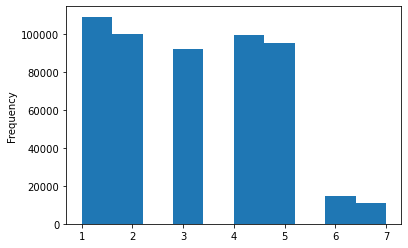

In [699]:
df_logins['day'].plot.hist()
plt.show()


Number of events per day

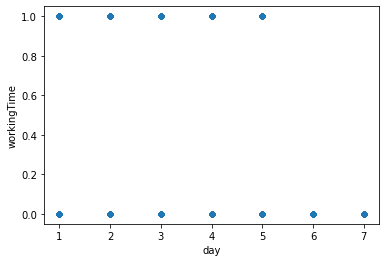

In [700]:
df_logins.plot(x = 'day', y = 'workingTime', kind = 'scatter')
plt.show()

Every log between Friday and Sunday occurred outside working time

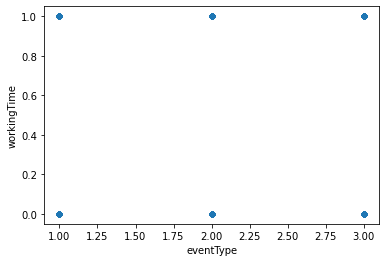

In [701]:
df_logins.plot(x = 'eventType', y = 'workingTime', kind = 'scatter')
plt.show()

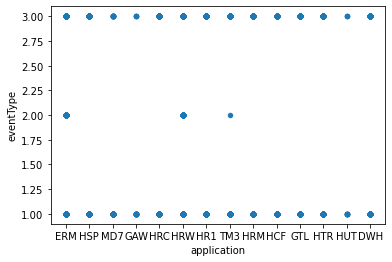

In [702]:
df_logins.plot(x = 'application', y = 'eventType', kind = 'scatter')
plt.show()

Failed logins attempts occurred only for application ERM (2), HRW (9) and TM3 (14) 

### Series dataframe construction

In [678]:
# group by the userId
df_groupbyUserId = df_logins.groupby('userId')

In [679]:
# Retrieving users id
users_id = []
for key, value in df_groupbyUserId:
    users_id.append(key)

# Take userId having 0 or 1 login errors
userList = []

for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    ctr = user_group[user_group["eventType"] == FAILED_LOGIN].count()
    if ctr["eventType"] <= 1:
        userList.append(i)

In [680]:
# remove from the dataset all the users in userList
df_logins = df_logins[df_logins["userId"].isin(userList) == False]
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
9680,10,2020-06-15 14:19:45,1,1,2,ERM,ip_2
9681,10,2020-11-04 10:56:10,3,1,2,ERM,ip_3
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


In [681]:
df_groupbyUserId = df_logins.groupby('userId')

In [682]:
# list of remaining userId 
users_id = [user for user in users_id if (user not in userList)]

userList.clear()

# getting all users having at least two login errors
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    j = 0
    while j < rowsNumber - 1:
        if user_group.iloc[j]["eventType"] == FAILED_LOGIN:
            k = j+1            
            while k < rowsNumber and user_group.iloc[k]["eventType"] != FAILED_LOGIN:
                k += 1
            if k == 1 or k != rowsNumber: # after a login error the user have other login errors (1 or more)
                userList.append(i)
                break
            j = k
        else:
            j += 1

[10,
 17,
 18,
 21,
 24,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 43,
 44,
 50,
 53,
 67,
 72,
 79,
 82,
 91,
 105,
 117,
 123,
 170,
 190,
 191,
 193,
 195,
 197,
 198,
 199,
 205,
 207,
 208,
 209,
 218,
 221,
 222,
 224,
 225,
 228,
 234,
 236,
 237,
 238,
 242,
 245,
 249,
 251,
 254,
 255,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 268,
 269,
 271,
 273,
 275,
 277,
 279,
 280,
 282,
 284,
 285,
 289,
 290,
 291,
 294,
 299,
 300,
 302,
 305,
 307,
 309,
 310,
 313,
 315,
 317,
 320,
 322,
 325,
 328,
 331,
 334,
 335,
 341,
 343,
 347,
 348,
 349,
 350,
 351,
 352,
 366,
 372,
 375,
 376,
 379,
 386,
 390,
 391,
 395,
 397,
 403,
 407,
 409,
 414,
 416,
 418,
 420,
 423,
 426,
 430,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 445,
 447,
 449,
 453,
 454,
 457,
 458,
 459,
 461,
 462,
 465,
 467,
 468,
 470,
 471,
 472,
 473,
 476,
 477,
 478,
 479,
 480,
 483,
 484,
 485,
 486,
 488,
 489,
 492,
 494,
 496,
 498,
 500,
 501,
 504,
 506,
 509,
 510,
 512,
 513,
 5

In [683]:
# remove all users having only successful attempts after an error
df_logins = df_logins[df_logins["userId"].isin(userList)]
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
9680,10,2020-06-15 14:19:45,1,1,2,ERM,ip_2
9681,10,2020-11-04 10:56:10,3,1,2,ERM,ip_3
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


In [684]:
df_groupbyUserId = df_logins.groupby('userId')

In [685]:
# list of remaining userId
users_id = [user for user in users_id if (user in userList)]

userList = []

# take all users who have at least 2 login errors in 24h
for i in users_id:
    user_group = df_groupbyUserId.get_group(i)
    rowsNumber = len(user_group.index)
    j = 0
    while j < rowsNumber - 1:
        if user_group.iloc[j]["eventType"] == FAILED_LOGIN:
            k = j+1          
            while k < rowsNumber and user_group.iloc[k]["eventType"] != FAILED_LOGIN:
                k += 1
            if k == 1 or k != rowsNumber:
                delta = (user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
                if delta < AT_LEAST_ONE_DAY:
                    userList.append(i) # save userId
                    break
            j = k
        else:
            j += 1


In [686]:
# remove all users who do not have 2 login errors in 24h
df_logins = df_logins[df_logins["userId"].isin(userList)]
df_logins.sample(SAMPLE)

,userId,date,day,workingTime,eventType,application,ip
9684,17,2021-02-02 09:04:05,2,1,2,ERM,ip_4
9685,17,2021-02-02 09:04:05,2,1,1,ERM,ip_4
9692,17,2021-03-04 10:30:15,4,1,2,ERM,ip_4
9694,17,2021-03-04 10:30:15,4,1,1,ERM,ip_4
9698,17,2021-03-04 10:30:22,4,1,2,ERM,ip_4
...,...,...,...,...,...,...,...
849533,33949,2021-06-28 15:11:01,1,1,2,ERM,ip_1285
849532,33949,2021-06-28 15:17:00,1,1,2,ERM,ip_1285
849531,33949,2021-06-28 15:17:22,1,1,2,ERM,ip_1285
849535,33949,2021-06-28 15:20:47,1,1,2,ERM,ip_1285


In [ ]:
df_groupbyUserId = df_logins.groupby('userId')

In [742]:
# find sequences of login errors

"""
key: userId
value: list of failed attempts series
"""
failedAttemptsSeries = dict()

# serie entry: (date, eventType, application, workingTime, day, ip)
def buildCouple(user_group,i):
    return (user_group.iloc[i]["date"],user_group.iloc[i]["eventType"],
            user_group.iloc[i]["application"],user_group.iloc[i]["workingTime"],
            user_group.iloc[i]["day"],user_group.iloc[i]["ip"])

# store serie into dictionary
def saveSerie(user_idex,record_index):
    failureSeries = failedAttemptsSeries[i]
    failureSeries.append(serie)
    failedAttemptsSeries[i] = failureSeries

# find series of login errors for each user considering each application which has failed attempts
for i in userList: # for each user
    user_group = df_groupbyUserId.get_group(i) # get login attempts for the user
    rowsNumber = len(user_group.index) # get number of logins attempts
    failedAttemptsSeries[i] = [] # initialize user's value into dictionary
    for app in ["ERM", "HRW", "TM3"]: # for each app
        serie = [] # initializing empty serie
        j = 0
        while(j < rowsNumber): # for each login attempt
            # if the attempt is an error for the current app
            if(user_group.iloc[j]["eventType"] == FAILED_LOGIN and user_group.iloc[j]["application"] == app):
                serie.append(buildCouple(user_group,j)) # append the first attempt to the serie
                k = j + 1
                loginSuccess = False
                eventFailure = False
                while(not eventFailure and k < (rowsNumber - 1) and not loginSuccess): # searching for the next attempt
                    # if the attempt is successful
                    if (user_group.iloc[k]["eventType"] == SUCCESSFUL_LOGIN and user_group.iloc[k]["application"] == app): # login eseguito correttamente dopo un fallimento
                        loginSuccess = True
                    # else, if the attempt is an error
                    elif (user_group.iloc[k]["eventType"] == FAILED_LOGIN and user_group.iloc[k]["application"] == app):
                         eventFailure = True
                    k += 1

                # for both event type
                if(eventFailure or loginSuccess):
                    # compute the time intervall in milliseconds between the two attempts
                    delta = (user_group.iloc[k]["date"] - user_group.iloc[j]["date"]).total_seconds() * 1000
                    
                    # in case the current failed attempt occurs in MAX_DELAY_ERRORS
                    if eventFailure and delta < MAX_DELAY_ERRORS:
                        serie.append(buildCouple(user_group,k-1)) # append to the current serie
                    # else
                    elif eventFailure and not delta < MAX_DELAY_ERRORS:
                        saveSerie(user_idex=i,record_index=k-1) # save the current serie
                        serie = [] # starting a new serie
                        serie.append(buildCouple(user_group,k-1)) # append the attempt
                    # in case the current successful attempt occur in MAX_DELAY_SUCCESS
                    elif loginSuccess and delta < MAX_DELAY_SUCCESS:
                        serie.append(buildCouple(user_group,k-1)) # append it to the current serie for closing it
                        saveSerie(user_idex=i,record_index=k-1) # save the serie
                        serie = [] # starting a new serie
                    # else
                    elif loginSuccess and not delta < MAX_DELAY_SUCCESS:
                        saveSerie(user_idex=i,record_index=k-1) # save the serie
                        serie = [] # starting a new one
                j = k
            
            # in case there is an open serie, it is closed
            # if successful attempt is found for the same application
            elif(len(serie) > 0 and user_group.iloc[k]["application"] == serie[len(serie) - 1][2]): 
                # check delay
                delta = (user_group.iloc[k]["date"] - serie[len(serie) - 1][0]).total_seconds() * 1000
                if(delta <  MAX_DELAY_SUCCESS):
                    serie.append(buildCouple(user_group,j))
                saveSerie(user_idex=i,record_index=j)
                serie = []
                j += 1
            else:
                j += 1
        
        # when attempts are over, save the serie
        if(len(serie) > 0):
            saveSerie(user_idex=i,record_index=j)
            serie = [] 
            


In [746]:
# failedAttemptsSeries

In [724]:
df_groupbyUserId1 = df_logins.groupby('userId').get_group(238)
df_groupbyUserId1

,userId,date,day,workingTime,eventType,application,ip
18425,238,2021-04-13 11:33:22,2,1,1,ERM,ip_219
18436,238,2021-04-13 11:33:59,2,1,1,HRW,unknown
18431,238,2021-04-19 06:23:12,1,0,1,ERM,ip_223
18438,238,2021-04-19 06:23:38,1,0,1,HRW,unknown
18443,238,2021-04-19 15:06:19,1,1,1,ERM,ip_223
18445,238,2021-04-19 15:06:50,1,1,1,HRW,unknown
18439,238,2021-04-27 12:59:14,2,1,1,ERM,ip_219
18435,238,2021-04-27 13:00:12,2,1,1,ERM,ip_219
18437,238,2021-04-27 13:03:09,2,1,1,HRW,unknown
18442,238,2021-04-27 13:04:16,2,1,1,ERM,ip_219


#### Computing metrics

In [747]:
# compute average time between attempts of the same serie

seriesEvalIndex = [] # 
for user in failedAttemptsSeries.keys():
    series = failedAttemptsSeries[user]
    #(userId,tempoMedio, tentativiFalliti, hasSuccess, applicazione)
    for serie in series:
        length = len(serie)
        i = 0
        delta = 0
        hasSuccess = False
        ctr = 1 #numero di indirizzi ip usati
        workingTime = 1
        while(i < length - 1):
            delta += (serie[i+1][0] - serie[i][0]).total_seconds() * 1000
            ctr += 1 if serie[i+1][5] != serie[i][5] else 0
            workingTime &= serie[i][3]
            i += 1
        hasSuccess = serie[-1][1] == 1
        t = (user, int(delta/(length-1 if length > 1 else length )) ,length - 1 if hasSuccess else length,1 if hasSuccess else 0,serie[0][2],workingTime,serie[i][4],ctr)
        seriesEvalIndex.append(t)

df_series = pd.DataFrame(seriesEvalIndex,columns=["userId","avgTime","failedAttempts","hasSuccess","application","workingTime","day","ipAmount"])
df_series["suspicious"] = 0
df_series

# TO FIX !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#df_series[df_series["ipAmount"] == 0]
#df_series.iloc[0]

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
0,17,0,1,0,ERM,1,2,1,0
1,17,0,1,1,ERM,1,4,1,0
2,17,0,1,0,ERM,1,4,1,0
3,17,0,1,0,ERM,1,4,1,0
4,17,0,1,1,ERM,1,4,1,0
...,...,...,...,...,...,...,...,...,...
41114,33928,80291000,2,0,ERM,1,2,2,0
41115,33934,55000,3,0,ERM,0,1,1,0
41116,33949,86900,11,0,ERM,1,5,1,0
41117,33949,273414000,2,0,ERM,1,1,2,0


In [748]:
#delete series with just one log err and average mean equal to 0
df_series.drop(df_series[ df_series["avgTime"] == 0 ].index,inplace=True)
df_series

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
9,18,14666,4,0,ERM,1,5,1,0
10,21,8000,2,1,ERM,1,4,1,0
12,24,7000,1,1,ERM,1,1,1,0
16,24,6000,1,1,ERM,1,1,1,0
17,24,7000,2,1,ERM,1,1,1,0
...,...,...,...,...,...,...,...,...,...
41114,33928,80291000,2,0,ERM,1,2,2,0
41115,33934,55000,3,0,ERM,0,1,1,0
41116,33949,86900,11,0,ERM,1,5,1,0
41117,33949,273414000,2,0,ERM,1,1,2,0


In [772]:
# suspicious

def suspicious(serie):
    """
    serie[0] = "userId"
    serie[1] = "avgTime"
    serie[2] = "failedAttempts"
    serie[3] = "hasSuccess"
    serie[4] = "application"
    serie[5] = "workingTime"
    serie[6] = "day"
    serie[7] = "ipAmount"
    serie[8] = "suspicious"
    """
    
    # weights
    timeW = timeWeight(serie[6], serie[5])
    ipAmount = 1 - (1/serie[7]) 
    serieW = serieWeight(serie[1], serie[2], serie[3])
    failedAttempts = 1- (1/serie[2])
    

    return ((15 * timeW) + (25 * ipAmount) + (60 * serieW))/100 # percentage
  


def timeWeight(day, isWorkingTime):
    weekDay = day in range(1,6)
    w = 0
    if isWorkingTime and weekDay:
        w = 0.45
    elif not isWorkingTime and weekDay:
        w = 0.55
    elif isWorkingTime and not weekDay:
        w = 0.85
    elif not isWorkingTime and not weekDay:
        w = 0.95
    return w


def serieWeight(avgTime, failedAttempts, hasSuccess): # AMPLIARE TENENDO CONTO DI FAILEDATTEMPS !!!!!!!!!!!!!!!!!!!
    w = 0
    timeLargerThanBot = avgTime > MAX_TIME_BOT
    trialsLessThanMax = failedAttempts <= MAX_ATTEMPTS
    if hasSuccess:
        if failedAttempts == 1:
            w = 0.01 if timeLargerThanBot else 0.1   
        elif trialsLessThanMax:
            w = 0.1 if timeLargerThanBot else 0.65
        else:
            w = getWeight(avgTime,failedAttempts)
    else:
        if failedAttempts == 1:
            w = 0.01 if timeLargerThanBot else 0.1
        elif trialsLessThanMax:
            w = 0.5 if timeLargerThanBot else 0.9
        else:
            w = getWeight(avgTime,failedAttempts)
    return w

import math as m

def getWeight(avgTime,failedAttempts):
    human = avgTime > MAX_TIME_BOT
    bot = m.cos(failedAttempts/avgTime)
    w = 0
    if human:
        if(failedAttempts < 9):
            w = 0.8
        else:
            w = 0.95
    else:
        w = bot
    return w

In [773]:
df_series['suspicious'] = df_series.apply(lambda row : suspicious(row), axis=1)

In [774]:
df_series[df_series["suspicious"] == df_series["suspicious"].max()]

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
34439,30493,44352,18,0,ERM,0,7,5,0.9125


In [752]:
df_series[df_series["failedAttempts"] == df_series["failedAttempts"].max()]

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
3767,2285,47928,43,0,ERM,0,4,1,0.5775


In [777]:
df_series[df_series["ipAmount"] == df_series["ipAmount"].max()]

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
21793,20272,92578,20,0,ERM,1,1,5,0.8375
24428,22342,42300,11,0,ERM,1,2,5,0.8375
30049,26685,80777,10,0,ERM,1,1,5,0.8375
34439,30493,44352,18,0,ERM,0,7,5,0.9125


In [778]:
df_series[(df_series["avgTime"] < 5000) & (df_series["failedAttempts"] > 3)].sort_values(by=['suspicious'])

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
10158,6229,1000,4,0,ERM,1,2,1,0.667495
30075,26694,2666,4,0,HRW,1,3,1,0.667499
24262,22215,3500,5,0,ERM,1,3,1,0.667499
24279,22215,3333,4,0,ERM,1,3,1,0.667500
35395,31002,4000,10,0,ERM,0,6,1,0.742498


In [696]:
byApp = df_series[df_series["suspicious"] > 0.5].groupby(by=["application"])
tmp = byApp.userId.count()
tmp

application
ERM    1457
HRW       1
Name: userId, dtype: int64

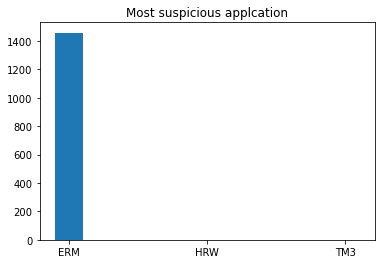

In [697]:
x = [k for k in tmp.keys()]
x.append("TM3")
y = [tmp[k] for k in tmp.keys()]
y.append(0)

plt.bar(x,y,width=0.2)
plt.title("Most suspicious applcation")
plt.show()

In [698]:
#

In [703]:
df_series

,userId,avgTime,failedAttempts,hasSuccess,application,workingTime,day,ipAmount,suspicious
3,17,8477500,2,1,ERM,1,4,1,0.1175
8,18,14666,4,0,ERM,1,5,1,0.3925
9,21,8000,2,1,ERM,1,4,1,0.1175
11,24,7000,1,1,ERM,1,1,1,0.0725
13,24,77000,1,1,ERM,1,1,1,0.0725
...,...,...,...,...,...,...,...,...,...
32886,33920,9387666,7,0,ERM,1,3,2,0.5675
32887,33928,26827333,3,1,ERM,1,2,2,0.5675
32888,33934,55000,3,0,ERM,0,1,1,0.4075
32889,33949,86900,11,0,ERM,1,5,1,0.4175


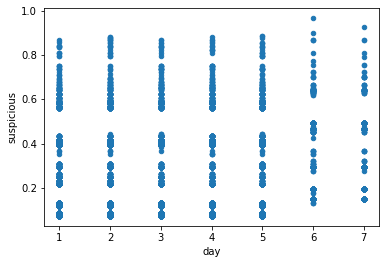

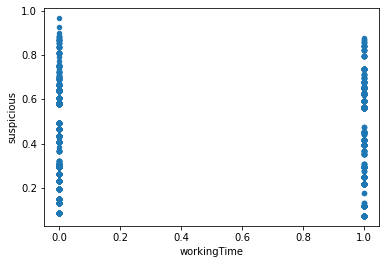

In [704]:
df_series.plot(x = 'day', y = 'suspicious', kind = 'scatter')
plt.show()
df_series.plot(x = 'workingTime', y = 'suspicious', kind = 'scatter')
plt.show()
#dal grafo possiamo dire che in ottica di attacchi cyber non è significativo basarsi sull'orario lavorativo 
#e giorno della settimana, in quanto abbiamo serie sospette indipendetemente dai parametri legati a questi fattori.
#

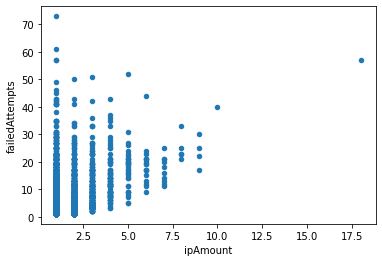

In [705]:
df_series.plot(x = 'ipAmount', y = 'failedAttempts', kind = 'scatter')
plt.show()
#il numero di indirizzi ip utilizzati non è strettamenre legato al numero di tentativi falliti 

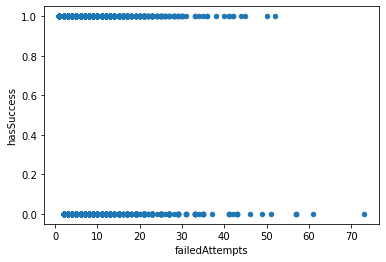

In [733]:
df_series.plot(x = 'failedAttempts', y = 'hasSuccess', kind = 'scatter')
plt.show()

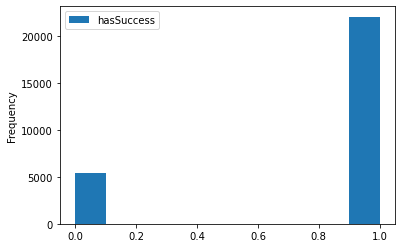

In [734]:
df_series.plot(x = 'failedAttempts', y = 'hasSuccess', kind = 'hist')
plt.show()

### Users dataframe construction

In [706]:
byUserId = df_series.groupby(by=["userId"])
meanSuspicous = byUserId["suspicious"].mean()
meanSuspicous

userId
17       0.117500
18       0.392500
21       0.117500
24       0.129167
33       0.117500
           ...   
33899    0.292500
33920    0.567500
33928    0.567500
33934    0.407500
33949    0.405000
Name: suspicious, Length: 8783, dtype: float64

In [707]:
users = []
for key, value in byUserId:
    users.append(key)

df_users = pd.DataFrame(columns=["userId","isSuspicious"])

df_users["userId"] = users
df_users["isSuspicious"] = meanSuspicous.values

df_users.sample(SAMPLE)

,userId,isSuspicious
3345,13731,0.392500
1987,5673,0.407500
1080,3099,0.240000
5339,22445,0.217500
6093,25150,0.095000
3658,15145,0.217500
6863,27648,0.262500
285,1032,0.187500
274,1007,0.097500
5081,21523,0.163333


In [709]:
df_users[df_users["isSuspicious"] == df_users["isSuspicious"].max()]

,userId,isSuspicious
5436,22788,0.888611


#### Plotting

<AxesSubplot:xlabel='userId', ylabel='isSuspicious'>

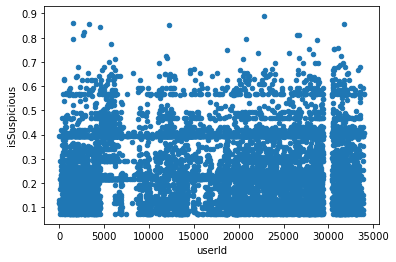

In [708]:
df_users.plot(kind="scatter",x="userId",y="isSuspicious")

suspicious --> range [0,1]
- 0 se non è un login sospetto
- 1 se è certo al 100% che il login è sospetto

Pesi:
- XXXXXX 1/avgBtw2loginErr                       --> tempo fra login errati minore di soglia
- XXXXXX 1/f(day & isWorkingTime) 
- XXXXXX 1 - (1/numeroIpUsati)                         --> login di errore eseguiti da ip diversi
- se ha login con successo --> vedo quanti tentativi ha fatto: 
    - se il numero di tentativi è <= 3 e il tempo è > del tempoBot --> assegno valore grande (0.1)
    - se il # tentativi <= 3 e il tempo è < del tempoBot --> assegno valore piccolo (0.7) (password corretta)
    - se il # tentativi > 3:
        - tempo > tempoBot --> 0.2 (utente stupido O collega che cerca di entrare)
        - tempo <= tempoBot --> 1.0 (bot entrato)
- altrimenti --> guardo il numero di tentativi:
    - <= 3 & tempo > tempoBot --> 0.3 (user ha dimenticato password)
    - <= 3 & tempo <= tempoBot --> 0.9 (bot cerca di entrare ma smette la ricerca presto)
    - > 3 & tempo > tempoBot --> 0.4 (user ha dimenticato password e cerca di entrare troppe volte)
    - > 3 & tempo < tempoBot --> 1.0 (bot cerca di entrare tante volte)


**suspicious = w1 * w2 * ... * wn**


<br>
<br>


Step process:
* XXXXXX cancello utenti che hanno #logerrati <= 1  --> abbiamo tutti gli utenti che hanno fatto 2 errori
* XXXXXX cancello tutti gli utenti che dopo 1 login errato hanno 1 login con successo (= digita male password)
* XXXXXX trovare sequenze consecutive di login errati
* XXXXXX calcolare tempo medio
* XXXXXX creare dataframe per anlisi finale
* XXXXXX scrivere regole per vlutare i parametri di una serie
* XXXXXX scrivere regole per valutare il tempo medio a seconda del numero e tipologia di eventi nella serie
* XXXXXX scrivere la funzione
* XXXXXX valutare tempo fra logerr e successivo (sia fallito che con successo)


- XXX sistemare serieWeight
- XXX scatter plot nuovi (+ scatterplot metric) + correlation analysis (se serve)
- XXX caratterizzare ogni utente come sospetto o meno considerando una media dei valori di suspicious
